<a href="https://colab.research.google.com/github/hernanmorales-navarrete/EPIC_4/blob/main/Day_2/Intro_DeepLearning_BioimageAnalysis/code/1_NoiseRemoval_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Noise Removal using Autoencoders


- This is a tutorial on the basic noise removal in bioimage analysis (i.e. fluorescence microscopy data) using AutoEcoders

## 1. Importing Modules & Packages

In [4]:
# Libraries for handling URL and file operations
import urllib                     # Library for handling URL operations
import os                         # Library for interacting with the operating system
import zipfile                    # Library for handling zip file operations

# Libraries for numerical and scientific computation
import numpy as np                # NumPy: manipulation of numerical arrays
import scipy.ndimage as ndi       # The image processing package scipy.ndimage
from scipy.ndimage import gaussian_filter  # Gaussian filter function from scipy.ndimage
from math import log10            # Math library for logarithmic calculations

# Libraries for data visualization and plotting
import matplotlib.pyplot as plt   # The plotting module matplotlib.pyplot as plt
import seaborn as sns             # Seaborn: data visualization library
import pandas as pd               # Pandas: data manipulation and analysis library

# Libraries for image processing and handling
from PIL import Image             # Pillow: image processing library
from skimage import io            # Scikit-image: image I/O
from skimage.metrics import structural_similarity as ssim  # SSIM: structural similarity index for image quality assessment

# Libraries for machine learning and neural networks
import torch                      # PyTorch: deep learning library
import torch.nn as nn             # PyTorch neural network module
import torch.optim as optim       # PyTorch optimization module
from torch.utils.data import DataLoader, Dataset  # DataLoader and Dataset modules from PyTorch
from torchvision import transforms  # Transforms module from torchvision for image transformations


In [5]:
# Set matplotlib backend
%matplotlib inline
#%matplotlib inline              # Displays as static figure in code cell output
#%matplotlib notebook            # Displays as interactive figure in code cell output
#%matplotlib qt                  # Displays as interactive figure in a separate window


In [6]:
# Check GPU
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4



## 2. Importing and save data

In [7]:
import urllib
import os
import zipfile

# create a folder for our data.
if not os.path.isdir('./data'):
    os.mkdir('./data')

# check if data has been downloaded already
zipPath="data/snr_7_binning_2.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('http://csbdeep.bioimagecomputing.com/example_data/snr_7_binning_2.zip', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

print("High and low SNR images downloaded from https://csbdeep.bioimagecomputing.com/")

High and low SNR images downloaded from https://csbdeep.bioimagecomputing.com/


In [8]:
# Alternative save data in drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Ploting image example from tre training set

In [9]:
# Function to rescale intensities
def rescale_intensity(image, Imin, Imax):
    """
    Rescale the intensity of an image from the range (Imin0, Imax0) to (Imin, Imax).

    Parameters:
    - image: numpy array, input image with intensity values in the range (Imin0, Imax0)
    - Imin: int or float, minimum intensity value in the output image
    - Imax: int or float, maximum intensity value in the output image

    Returns:
    - numpy array, image with intensity values rescaled to the range (0, 255)
    """
    # get min and max values
    Imin0 = np.amin(image)
    Imax0 = np.amax(image)

    # Save the original data type of the image
    original_dtype = image.dtype

    # Convert image to float for operations
    image = image.astype(float)

    # Rescale the intensities
    rescaled_image = ((image - Imin0) / (Imax0 - Imin0))  # Nomrlaizes to (0,1)
    rescaled_image = (rescaled_image * (Imax - Imin)) + Imin  # Scales to (Imin, Imax)

    # Clip the values to ensure they are within [0, 255]
    rescaled_image = np.clip(rescaled_image, Imin, Imax)

    # Convert back to the original data type
    rescaled_image = rescaled_image.astype(original_dtype)

    return rescaled_image

In [10]:
# Function to plot pairs of images

def pltPair(img1, img2, title1, title2, cmap1, cmap2, lim, fig_size):
    """This function displays a pair of input image with interpolation='none',in the range of lims. """

    plt.figure(figsize=(fig_size,fig_size))
    plt.subplot(1,2,1)
    plt.imshow(img1, interpolation='none', cmap=cmap1, vmin=lim[0], vmax=lim[1])
    plt.title(title1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(1,2,2)
    plt.imshow(img2, interpolation='none', cmap=cmap2, vmin=lim[2], vmax=lim[3])
    plt.title(title2)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()




In [11]:
# Create string variables for the path of the file to load (r before your string creates a 'raw string')

filename_lowSNR  = r'/content/data/train/low/img_0000.tif'
filename_highSNR = r'/content/data/train/GT/img_0000.tif'


In [12]:
# Load the images

# Import the function 'imread' from the module 'skimage.io'.
from skimage.io import imread

img_lowSNR  = imread(filename_lowSNR)
img_highSNR = imread(filename_highSNR)

print('Variable Type: ', type(img_lowSNR))
print('Image data type: ', img_lowSNR.dtype)
print('Image dimension: ', img_lowSNR.shape)
print('Max Intensity low SNR: ', np.amin(img_lowSNR))
print('Min Intensity low SNR: ', np.amax(img_lowSNR))
print('Max Intensity high SNR: ', np.amin(img_highSNR))
print('Min Intensity high SNR: ', np.amax(img_highSNR))


Variable Type:  <class 'numpy.ndarray'>
Image data type:  uint16
Image dimension:  (256, 256)
Max Intensity low SNR:  0
Min Intensity low SNR:  71
Max Intensity high SNR:  119
Min Intensity high SNR:  1307


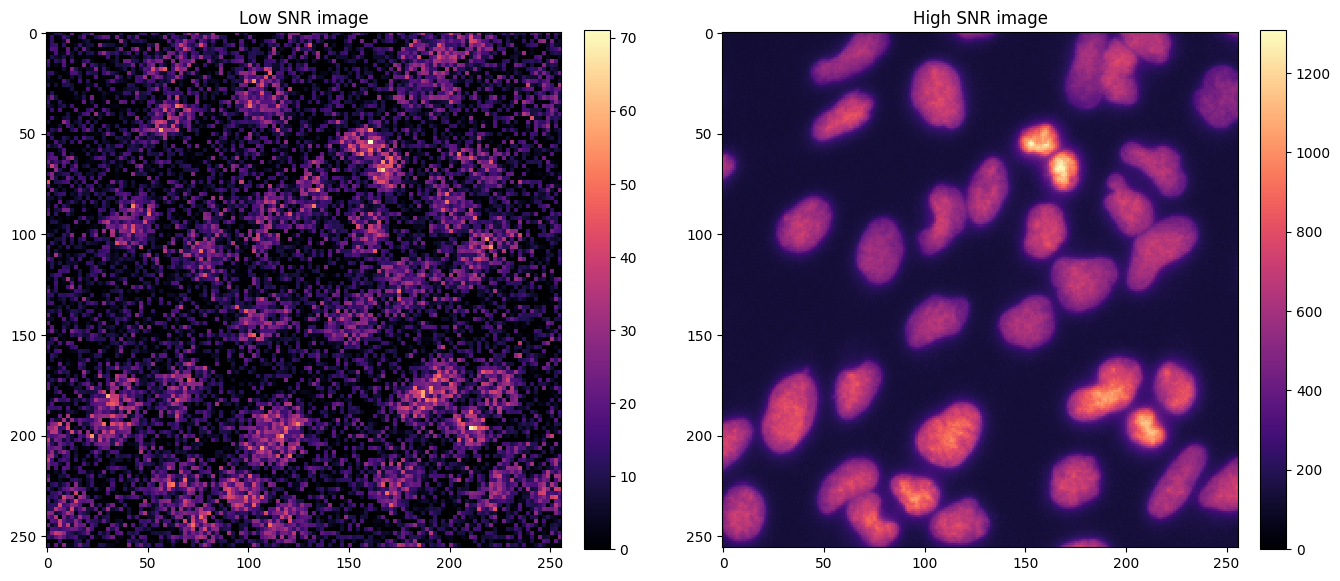

In [13]:
# Plot images

pltPair(img_lowSNR, img_highSNR, 'Low SNR image', 'High SNR image', 'magma', 'magma', [0,71,0,1307], 16)

Max Intensity low SNR:  0
Min Intensity low SNR:  255
Max Intensity high SNR:  0
Min Intensity high SNR:  255


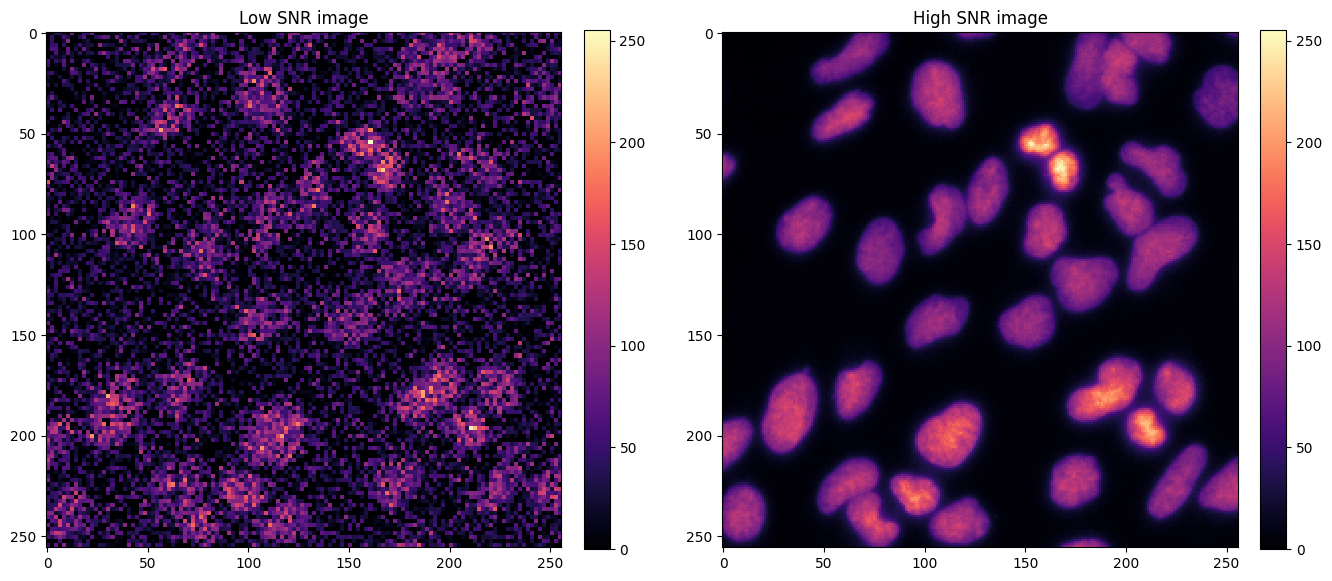

In [14]:
img_lowSNR = rescale_intensity(img_lowSNR, 0, 255)
img_highSNR = rescale_intensity(img_highSNR, 0, 255)

print('Max Intensity low SNR: ', np.amin(img_lowSNR))
print('Min Intensity low SNR: ', np.amax(img_lowSNR))
print('Max Intensity high SNR: ', np.amin(img_highSNR))
print('Min Intensity high SNR: ', np.amax(img_highSNR))


pltPair(img_lowSNR, img_highSNR, 'Low SNR image', 'High SNR image', 'magma', 'magma', [0,255,0,255], 16)

## 4. Image Denoising using classic image processing methods


### Image Filtering

- Removing noise and preserving the structures of interest.

- Genereal noised reduction (smoothing) using a `Gaussian filter`

- Gaussian Smoothing : Gaussian kernel is determined by the standard deviation ($\sigma$) of the Gaussian distribution
- $\sigma$ : large enough to blur out noise but small enough to keep structures of interest

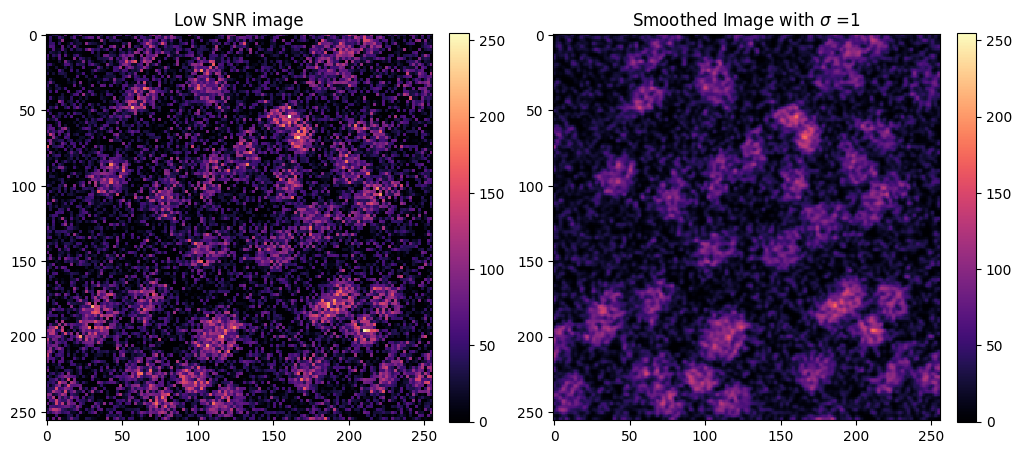

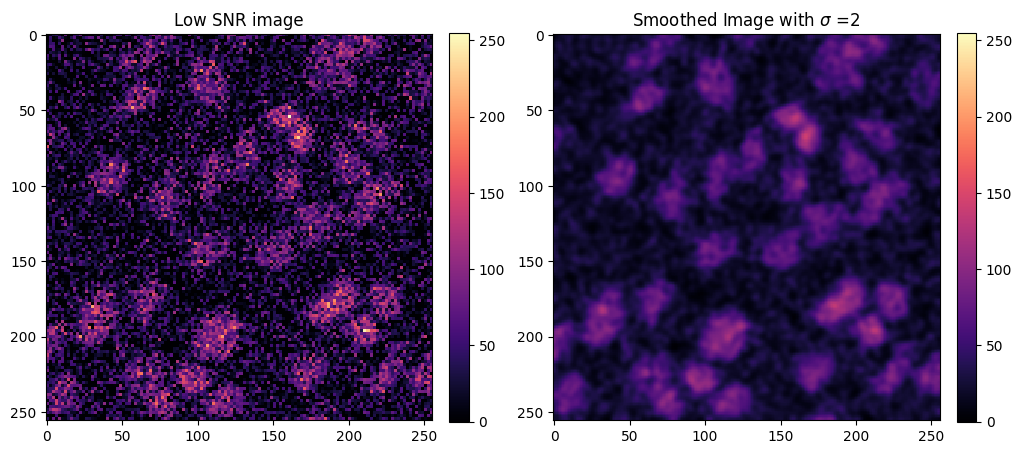

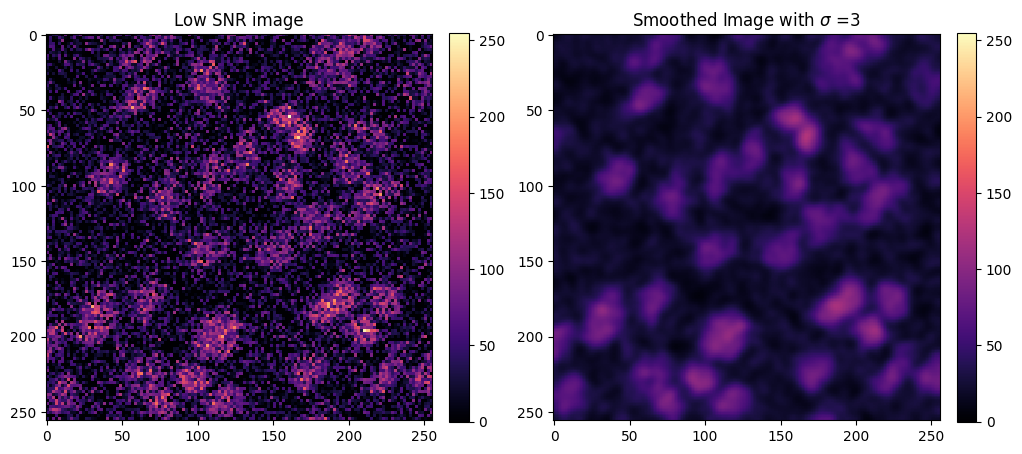

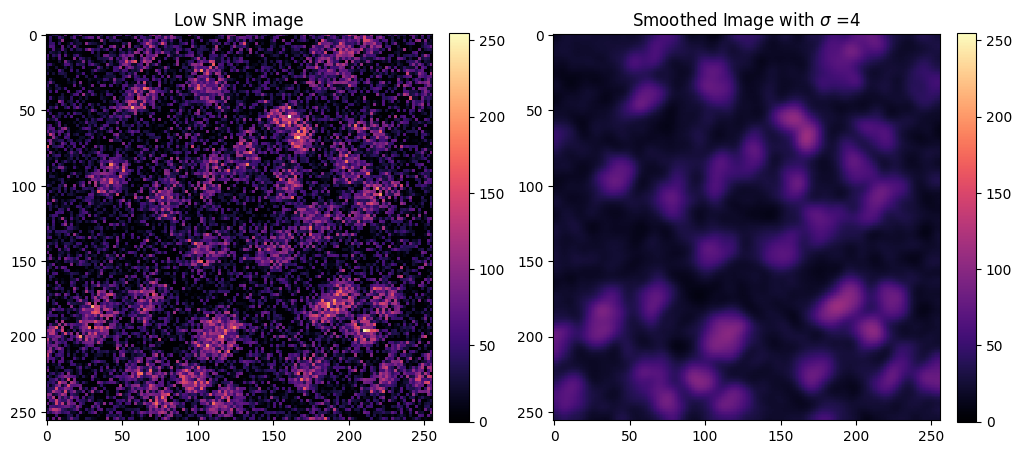

In [15]:
# Test for several values for the smoothing factor sigma
# note: range(start_value, end_value, step)
# Use the Gaussian filter function 'ndi.filters.gaussian_filter' from the 'scipy.ndimage'

for sigma in range(1, 5, 1):
    img_smooth_test = ndi.gaussian_filter(img_lowSNR, sigma)
    txt = "$\sigma$ =" + str(sigma)
    pltPair(img_lowSNR, img_smooth_test, 'Low SNR image', 'Smoothed Image with '+"$\sigma$ =" + str(sigma), 'magma', 'magma', [0,255,0,255], 12)


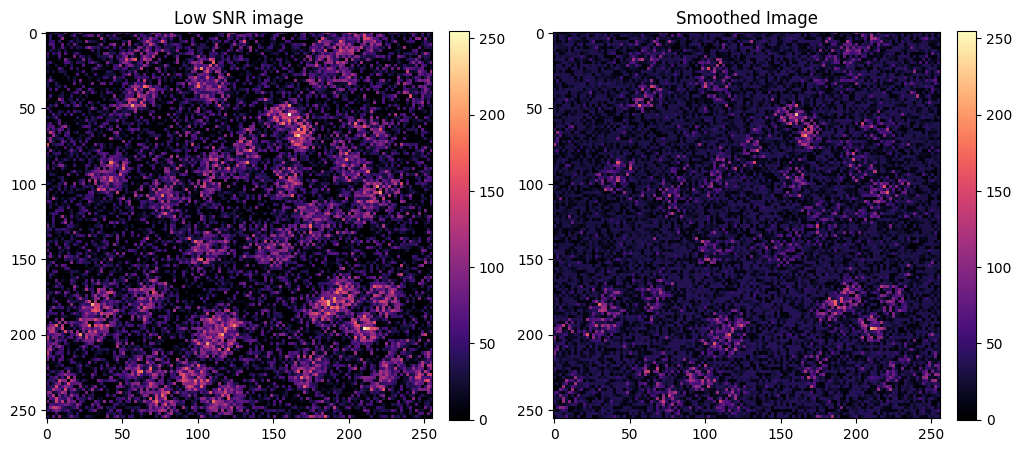

In [16]:
# Perform FFT
f = np.fft.fft2(img_lowSNR)
fshift = np.fft.fftshift(f)

# Create a mask with a central square of 1s
rows, cols = img_lowSNR.shape
crow, ccol = rows//2 , cols//2
mask = np.ones((rows, cols), np.uint8)
r = 1  # Radius of the central square
mask[crow-r:crow+r, ccol-r:ccol+r] = 0

# Apply mask and inverse FFT
fshift = fshift * mask
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

pltPair(img_lowSNR, img_back, 'Low SNR image', 'Smoothed Image', 'magma', 'magma', [0,255,0,255], 12)



## 4. Image Denoising using autoencoders


### Load images

In [17]:
# Custom dataset for loading images

class NoisyImageDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.transform = transform
        self.noisy_images = os.listdir(noisy_dir)
        self.clean_images = os.listdir(clean_dir)

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        noisy_img_path = os.path.join(self.noisy_dir, self.noisy_images[idx])
        clean_img_path = os.path.join(self.clean_dir, self.clean_images[idx])
        noisy_image = io.imread(noisy_img_path)
        clean_image = io.imread(clean_img_path)

        if self.transform:
            noisy_image = self.transform(noisy_image)
            clean_image = self.transform(clean_image)

        return noisy_image, clean_image

# Transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load datasets
train_dataset = NoisyImageDataset(noisy_dir='/content/data/train/low/', clean_dir='/content/data/train/low/', transform=transform)
test_dataset  = NoisyImageDataset(noisy_dir='/content/data/test/low/',  clean_dir='/content/data/test/GT',    transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Plot some images as examples

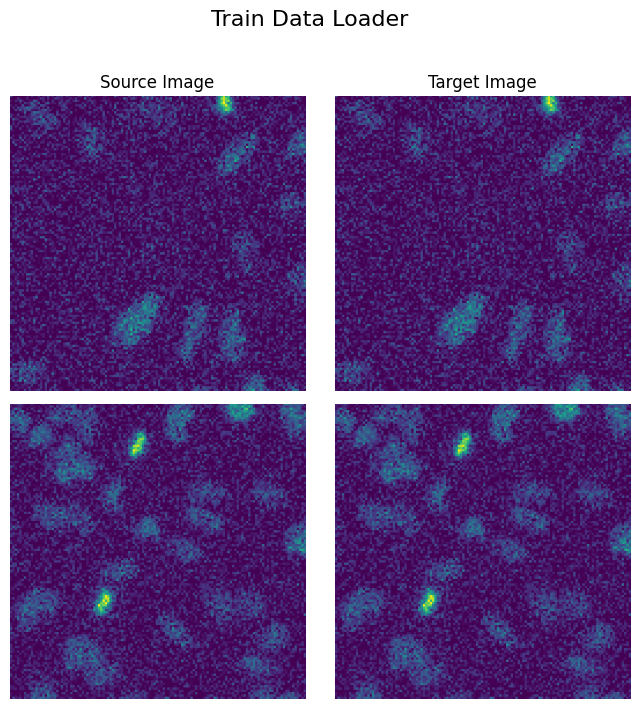

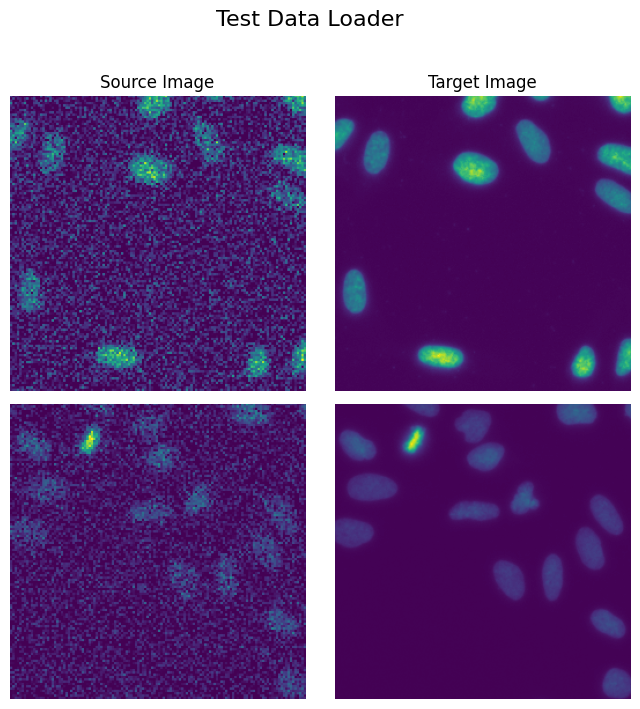

In [18]:
# Function to plot image pairs
def plot_image_pairs(data_loader, title, Nimages):
    data_iter = iter(data_loader)
    fig, axes = plt.subplots(nrows=Nimages, ncols=2, figsize=(8, 4*Nimages))
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(wspace=0.1, hspace=0) # Adjust the spacing between subplots
    noisy_images, clean_images = next(data_iter) # get N pairs of images, N = batchc size

    # Plot fewer image pairs than the batch size
    if Nimages > noisy_images.shape[0]:
        Nimages = noisy_images.shape[0]

    for i in range(Nimages):
      axes[i, 0].imshow(np.squeeze(noisy_images[i]))
      #print(np.amax(noisy_images[i,:,:,:]))
      #print(np.amin(noisy_images[i,:,:,:]))
      axes[i, 0].axis('off')
      axes[i, 1].imshow(np.squeeze(clean_images[i]))
      axes[i, 1].axis('off')
      if i == 0:
          axes[i, 0].set_title('Source Image', fontsize=12)
          axes[i, 1].set_title('Target Image', fontsize=12)
    plt.show()

# Plotting train and test image pairs
plot_image_pairs(train_loader, "Train Data Loader", 2)
plot_image_pairs(test_loader, "Test Data Loader", 2)

## Define Autoencoder model

In [19]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [20]:
# Instantiate and train the model
model = Autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    for data in train_loader:
        noisy_imgs, _ = data
        noisy_imgs = noisy_imgs.cuda()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, noisy_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Visualize the results
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(img, cmap='gray')
    plt.show()

model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        noisy_imgs, clean_imgs = data
        noisy_imgs = noisy_imgs.cuda()
        outputs = model(noisy_imgs)

        for j in range(min(len(outputs), 5)):
            print("Original Noisy Image")
            imshow(noisy_imgs[j])
            print("Denoised Image")
            imshow(outputs[j])
            print("Ground Truth Image")
            imshow(clean_imgs[j])

# Comparison with Gaussian filter
def apply_gaussian_filter(img, sigma=2):
    return torch.tensor(gaussian_filter(img.cpu().numpy(), sigma=sigma)).unsqueeze(0)

# Metrics
psnr_list, ssim_list, rmse_list = [], [], []
psnr_gaussian, ssim_gaussian, rmse_gaussian = [], [], []

def calculate_metrics(clean, denoised):
    mse = mean_squared_error(clean, denoised)
    psnr = 10 * log10(1 / mse)
    s = ssim(clean, denoised)
    rmse = np.sqrt(mse)
    return psnr, s, rmse

with torch.no_grad():
    for i, data in enumerate(test_loader):
        noisy_imgs, clean_imgs = data
        noisy_imgs, clean_imgs = noisy_imgs.cuda(), clean_imgs.cuda()
        outputs = model(noisy_imgs)

        for j in range(len(outputs)):
            clean = clean_imgs[j].cpu().numpy().squeeze()
            denoised = outputs[j].cpu().numpy().squeeze()
            psnr, s, rmse = calculate_metrics(clean, denoised)
            psnr_list.append(psnr)
            ssim_list.append(s)
            rmse_list.append(rmse)

            gaussian_img = apply_gaussian_filter(noisy_imgs[j])
            psnr_g, s_g, rmse_g = calculate_metrics(clean, gaussian_img.numpy().squeeze())
            psnr_gaussian.append(psnr_g)
            ssim_gaussian.append(s_g)
            rmse_gaussian.append(rmse_g)

# Plotting results
metrics_df = pd.DataFrame({
    'PSNR Autoencoder': psnr_list,
    'PSNR Gaussian': psnr_gaussian,
    'SSIM Autoencoder': ssim_list,
    'SSIM Gaussian': ssim_gaussian,
    'RMSE Autoencoder': rmse_list,
    'RMSE Gaussian': rmse_gaussian,
})

sns.violinplot(data=metrics_df, inner="quartile")
plt.title('Metrics Comparison')
plt.show()



RuntimeError: Input type (short unsigned int) and bias type (float) should be the same

----

*For some users, it is necessary to specifically activate the widgets plugin for Jupyter notebook. To do so, save and exit Jupyter notebook, then go to a terminal and write `jupyter nbextension enable --py --sys-prefix widgetsnbextension`.

#### Automatic Thresholding

- There are several algorithm for autoimatic thrshold detection
- 'skimage.filters.thresholding' provides several threshold detection algorithms
- One of the most popular : Otsu's method.

In [ ]:
# Import
from skimage.filters.thresholding import threshold_otsu

# Calculate and apply threshold
thresh = threshold_otsu(img_smooth)
mem = img_smooth > thresh
print('Throshold by Otsu = ', str(thresh))

# Visualization
pltPair(img_smooth, mem, 'Smoothed Image', 'Thresholded Membranes with Otsu', 'magma', 'gray', [0,255,0,1])



In [ ]:
# You can asl try all algorithms aviable in 'skimage.filters.thresholding'
from skimage.filters.thresholding import try_all_threshold
fig = try_all_threshold(img_smooth, figsize=(12,12), verbose=False)

#### Adaptive Thresholding

- Adaptive thresholding algorithm, which adjusts the threshold locally in different regions of the image to account for varying intensities
- scikit-image provides a function for adaptive thresholding called threshold_local
- Here step by step :
    - Generation of a "background image"
    - Thresholding of the original image with the background

In [ ]:
# Generation of a "background image"

# Generate a blurred image with large sigma
largeSigma = 19
bg = ndi.filters.gaussian_filter(img_smooth, largeSigma)

# Vizualization
pltPair(img_smooth, bg, 'Smoothed Image', 'Background image', 'magma', 'magma', [0,255,0,255])

In [ ]:
# Threshold the smoothed original image against the background image

mem = img_smooth > bg

# Visualization
pltPair(img_smooth, mem, 'Smoothed Image', 'Adaptative Threshold', 'magma', 'gray', [0,255,0,1])



## 5. Binary Morphological operations
 - Improving masks
 - Morphological operations such as erosion, dilation, closing and opening
 - Fill small holes, remove noise, increase or decrease the size of an object
 - Simple kernel functions that are applied at each pixel of the image based on their neighborhood as defined by a structuring element (SE)
 - Dilation assigns to the central pixel the maximum pixel value within the neighborhood (maximun filter)
 - Erosion is a minimum filter.

In [ ]:
# Remove speckles using binary hole filling

# Use the function 'ndi.binary_fill_holes' for this. Be sure to check the docs to
# understand exactly what it does. For this to work as intended, you will have to
# invert the mask, which you can do using the function `np.logical_not` or the
# corresponding operator '~'. Again, be sure to understand why this has to be done
# and don't forget to revert the result back.

#mem_holefilled = np.logical_not(ndi.binary_fill_holes(np.logical_not(mem)))  # Long form
mem_final = ~ndi.binary_fill_holes(~mem)  # Short form

# Visualization
pltPair(mem, mem_final, 'Binary Image', 'Binary Image after filling holes', 'gray', 'gray', [0,1,0,1])


## 6. Cells segmentation

###  Connected Components Labeling

- Goal identify individual cells as single objects (with unique ID)
- Using 'connected components labeling'. It gives every connected group of foreground pixels a unique ID number.

In [ ]:
# Label connected components

# Use the function 'ndi.label' from the 'ndimage' module.

cell_labels, _ = ndi.label(~mem_final)

iMax = cell_labels.max();
print(str(iMax), ' cells detected')
pltPair(mem_final, cell_labels,'Membranes', 'Cell Labels', 'gray', 'jet', [0,1,0,iMax])

### Seeding and Expansion

- Expansion algorithms such as the watershed start from a small seed and "grow outward" until they touch the boundaries of neighboring cells

#### Seeding by Distance Transform
- A `seed image` contains a few pixels at the center of each cell labeled by a unique `ID` number
- If Nuclei image is avaible, use it as seeds
- Alternatively:  `distance transform` and `local maxima` for seeding

In [ ]:
# Run a distance transform on the membrane mask
# Use the function 'ndi.distance_transform_edt'.

dist_trans = ndi.distance_transform_edt(~mem_final)
dMax = dist_trans.max();
pltPair(mem_final, dist_trans,'Membranes', 'Distance Transform', 'gray', 'magma', [0,1,0,dMax])

In [ ]:
# Smoothen the distance transform

dist_trans_smooth = ndi.filters.gaussian_filter(dist_trans, sigma=5)
dMax = dist_trans_smooth.max();
pltPair(mem_final, dist_trans_smooth,'Membranes', 'Distance Transform Smooth', 'gray', 'magma', [0,1,0,dMax])


In [ ]:
# Get the local maxima from the distance transform
# Use the function 'peak_local_max' from the module 'skimage.feature'.

from skimage.feature import peak_local_max
seeds = peak_local_max(dist_trans_smooth, indices=False,  min_distance=10)

# Dilate seeds : for vizualization
seeds_dil = ndi.filters.maximum_filter(seeds, size=10)

pltPair(img_smooth, seeds_dil, 'Smooth image', 'Seeds', 'gray', 'jet', [0,255,0,1])

In [ ]:
# Visualize the output as an overlay on the smoothed image


plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_dil, mask=seeds_dil==0), interpolation='none', cmap='autumn')
plt.show()

In [ ]:
# Label the seeds using connected component

# Use connected component labeling to give each cell seed a unique ID number.
seeds_labeled,_ = ndi.label(seeds)

# Visualize the final result
seeds_labeled_dil = ndi.filters.maximum_filter(seeds_labeled, size=10)  # Expand a bit for visualization
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_labeled_dil, mask=seeds_labeled_dil==0), interpolation='none', cmap='prism')
plt.show()

#### Expansion by Watershed

In [ ]:
# Perform watershed
# Use the function 'watershed' from the module 'skimage.morphology'.

from skimage.segmentation import watershed
ws = watershed(img_smooth, seeds_labeled)

nCells0 = ws.max();
print(str(nCells0), ' cells detected')
pltPair(img_smooth, ws, 'Smooth image', 'Watershed', 'gray', 'jet', [0,255,0,nCells0])
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(ws, interpolation='none', cmap='prism', alpha=0.4)
plt.show()

## 7. Postprocessing

###  Removing Cells at the Image Border

In [ ]:
# Create an image border mask

border_mask = np.zeros(ws.shape, dtype=bool)
border_mask = ndi.binary_dilation(border_mask, border_value=1)

# Remove the cells at the border

# Create a copy of the initial result
clean_ws = np.copy(ws)

for cell_ID in np.unique(ws):

    # Create a mask that contains only the 'current' cell of the iteration
    cell_mask = ws==cell_ID

    # Use the cell mask and the border mask to test if the cell has pixels touching
    # the image border or not.
    cell_border_overlap = np.logical_and(cell_mask, border_mask)  # Overlap of cell mask and boundary mask
    total_overlap_pixels = np.sum(cell_border_overlap)            # Sum overlapping pixels

    # If a cell touches the image boundary, delete it by setting its pixels in the segmentation to 0.
    if total_overlap_pixels > 0:
        clean_ws[cell_mask] = 0

# Re-label the remaining cells to keep the numbering consistent from 1 to N (with 0 as background).

for new_ID, cell_ID in enumerate(np.unique(clean_ws)[1:]):  # The [1:] excludes 0 from the list (background)!
    clean_ws[clean_ws==cell_ID] = new_ID+1                  # The same here for the +1

nCells = clean_ws.max();
print(str(nCells), ' cells detected after removing the ones at the border')
pltPair(ws, clean_ws, 'Cells initial', 'Cells final', 'jet', 'jet', [0,255,0,nCells])
plt.show()


### Identifying Cell Edges

- Create cell edge mask
- For each cell:
    - Erode the cell's mask by 1 pixel
    - Using the eroded mask and the original mask, create a new mask of only the cell's edge pixels

In [ ]:
# Create cell edge mask
edges = np.zeros_like(clean_ws)

# Iterate over the cell IDs
for cell_ID in np.unique(clean_ws)[1:]:

    # Erode the cell's mask by 1 pixel using 'ndi.binary_erode'
    cell_mask = clean_ws==cell_ID
    eroded_cell_mask = ndi.binary_erosion(cell_mask, iterations=1) #

    # Create the cell edge mask using 'np.logical_xor'
    edge_mask = np.logical_xor(cell_mask, eroded_cell_mask)

    # Add the cell edge mask to the empty array generated above, labeling it with the cell's ID
    edges[edge_mask] = cell_ID

# Vizualize
maskEdges = np.ma.array(edges, mask=edges==0)
pltPair(img_smooth[100:200, 100:200], maskEdges[100:200, 100:200], 'Smooth image', 'Cell edges', 'gray', 'prism', [0,255,0,nCells])
plt.show()

## 8. Extracting Quantitative Measurements

Measure different properties of cells:

- Cell ID
- Mean intensity of each cell
- Mean intensity at the membrane of each cell
- The cell area, i.e. the number of pixels that make up the cell
- The cell outline length, i.e. the number of pixels that make up the cell edge


In [ ]:
# Create a dictionary that contains a key-value pairing for each measurement

results = {"cell_id"      : [],
           "int_mean"     : [],
           "int_mem_mean" : [],
           "cell_area"    : [],
           "cell_edge"    : []}


# Run calculations for each cell

for cell_id in np.unique(clean_ws)[1:]:

    # Mask the current cell and cell edge
    cell_mask = clean_ws==cell_id
    edge_mask = edges==cell_id

    # Get the measurements
    results["cell_id"].append(cell_id)
    results["int_mean"].append(np.mean(img[cell_mask]))
    results["int_mem_mean"].append(np.mean(img[edge_mask]))
    results["cell_area"].append(np.sum(cell_mask))
    results["cell_edge"].append(np.sum(edge_mask))

# Print the results
for key in results.keys():
    print(key + ":", results[key][:5], '\n')

## Analysis & Visualisation

In [ ]:
# (i) Get summarize the results


# Custom function for printing of summary statistics.
# Note the use of format strings for nice number padding.
def print_summary(data):
    print( "  Mean:    {:7.2f}".format(np.mean(data))   )
    print( "  Stdev:   {:7.2f}".format(np.std(data))    )
    print( "  Max:     {:7.2f}".format(np.max(data))    )
    print( "  Min:     {:7.2f}".format(np.min(data))    )
    print( "  Median:  {:7.2f}".format(np.median(data)) )

# Calling the custom function for each dataset
for key in results.keys():
    print( '\n'+key )
    print_summary(results[key])


In [ ]:
# Using  pre-made functions to get summary statistics : 'scipy.stats.describe'.
from scipy.stats import describe
stat_summary = describe(results['int_mean'])

print( '\nscipy.stats.describe of int_mean' )
for key in stat_summary._asdict().keys():
    print( ' ', key+': ', stat_summary._asdict()[key] )

In [ ]:
# Create a box plot showing the mean cell and mean membrane intensities  using 'plt.boxplot'.

plt.figure(figsize=(3,6))
plt.boxplot([results['int_mean'], results['int_mem_mean']],
            labels=['int_mean', 'int_mem_mean'],
            widths=0.6, notch=True)
plt.show()

In [ ]:
# Scatter plot of cell outline length over cell area using 'plt.scatter'

plt.figure(figsize=(8,5))
plt.scatter(results["cell_area"], results["cell_edge"],
            edgecolor='k', s=30, alpha=0.5)
plt.xlabel("cell area [pxl^2]")
plt.ylabel("cell edge length [pxl]")

cell_area_range = np.linspace(min(results["cell_area"]), max(results["cell_area"]), num=100)
circle_circumference = 2 * np.pi * np.sqrt( cell_area_range / np.pi )
plt.plot(cell_area_range, circle_circumference, color='r', alpha=0.8)
plt.legend(['circles', 'data'], loc=2, fontsize=10)
plt.show()

In [ ]:
# Map the cell area back onto the image as a 'heatmap'

# 'Normalized' area for vizualization
areas_8bit = np.array(results["cell_area"]) / max(results["cell_area"]) * 255

area_map = np.zeros_like(clean_ws, dtype=np.uint8)

# Iterate over the segmented cells.

for index, cell_id in enumerate(results["cell_id"]):
    # Mask the current cell and assign the cell's (re-scaled) area value to the cell's pixels.
    area_map[clean_ws==cell_id] = areas_8bit[index]


# Create the plot
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(area_map,interpolation='none', cmap='jet', alpha=0.6)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()